# 데이터셋 다운로드

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'oreocube' # username
os.environ['KAGGLE_KEY'] = '6eccd7011bed88a9e3cdc213d8761acb' # key

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip -q intel-image-classification.zip

 97% 336M/346M [00:04<00:00, 92.0MB/s]
100% 346M/346M [00:04<00:00, 87.0MB/s]


# 패키지 임포트

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# 이미지 증강 기법 사용해서 전처리하기

In [ ]:
train_datagen = ImageDataGenerator(
    rescale= 1./255, # 일반화
    rotation_range= 10, # 랜덤하게 이미지를 회전(단위: 도, 0-180)
    zoom_range= 0.1, # 랜덤하게 이미지 확대 (%)
    width_shift_range= 0.1, # 랜덤하게 이미지를 수평으로 이동 (%)
    height_shift_range= 0.1, # 랜덤하게 이미지를 수직으로 이동 (%)
    horizontal_flip= True # 랜덤하게 이미지를 수평으로 뒤집기
)

train_gen = train_datagen.flow_from_directory(
    'seg_train/seg_train',
    target_size=(224,224), # (height, width)
    batch_size=32,
    seed=2021,
    class_mode='categorical',
    shuffle=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_gen = test_datagen.flow_from_directory(
    'seg_test/seg_test',
    target_size=(224,224), # (height, width)
    batch_size=32,
    seed=2021,
    class_mode='categorical',
    shuffle=False
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# 데이터 확인하기

In [ ]:
from pprint import pprint
pprint(train_gen.class_indices)

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}


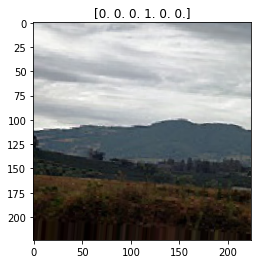

In [ ]:
preview_batch = train_gen.__getitem__(0) # 0번 배치의 이미지를 가져와라

preview_imgs, preview_labels = preview_batch

plt.title(str(preview_labels[0])) # 0번 이미지의 라벨
plt.imshow(preview_imgs[0])  # 0번 이미지

# 전이학습 - ResNet 모델 가져와서 수정하기

In [ ]:
from tensorflow.keras.applications import ResNet50

input = Input(shape=(224, 224, 3))

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input, pooling='max')

x = base_model.output
x = Dropout(rate=0.25)(x)
x = Dense(256, activation='relu')(x)
output = Dense(6, activation='softmax')(x)

model = Model(inputs= base_model.input, outputs= output)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['acc'])

model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________

# 학습

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

history = model.fit(
    train_gen, 
    validation_data = test_gen,
    epochs=20,
    callbacks=[
               ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)
    ]
)

Epoch 1/20
439/439 [==============================] - 382s 783ms/step - loss: 0.9541 - acc: 0.7652 - val_loss: 2.2849 - val_acc: 0.1700

Epoch 00001: val_acc improved from -inf to 0.17000, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
439/439 [==============================] - 340s 773ms/step - loss: 0.4200 - acc: 0.8556 - val_loss: 0.5519 - val_acc: 0.7980

Epoch 00002: val_acc improved from 0.17000 to 0.79800, saving model to model.h5
Epoch 3/20
439/439 [==============================] - 340s 774ms/step - loss: 0.3764 - acc: 0.8703 - val_loss: 0.3816 - val_acc: 0.8640

Epoch 00003: val_acc improved from 0.79800 to 0.86400, saving model to model.h5
Epoch 4/20
439/439 [==============================] - 340s 773ms/step - loss: 0.3478 - acc: 0.8799 - val_loss: 1.8566 - val_acc: 0.4703

Epoch 00004: val_acc did not improve from 0.86400
Epoch 5/20
439/439 [==============================] - 340s 774ms/step - loss: 0.3305 - acc: 0.8863 - val_loss: 1.4665 - val_acc: 0.6123

Epoch 00005: val_acc did not improve from 0.86400
Epoch 6/20
439/439 [==============================] - 340s 774ms/step - loss: 0.3361 - acc: 0.8849 - val_loss: 1.0829 - val_acc: 0.6553

Epoch 00006: val_acc did not improve from 0.86400
Epoch

# 학습된 모델 로드

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')

print('Model loaded!')

Model loaded!


# 테스트

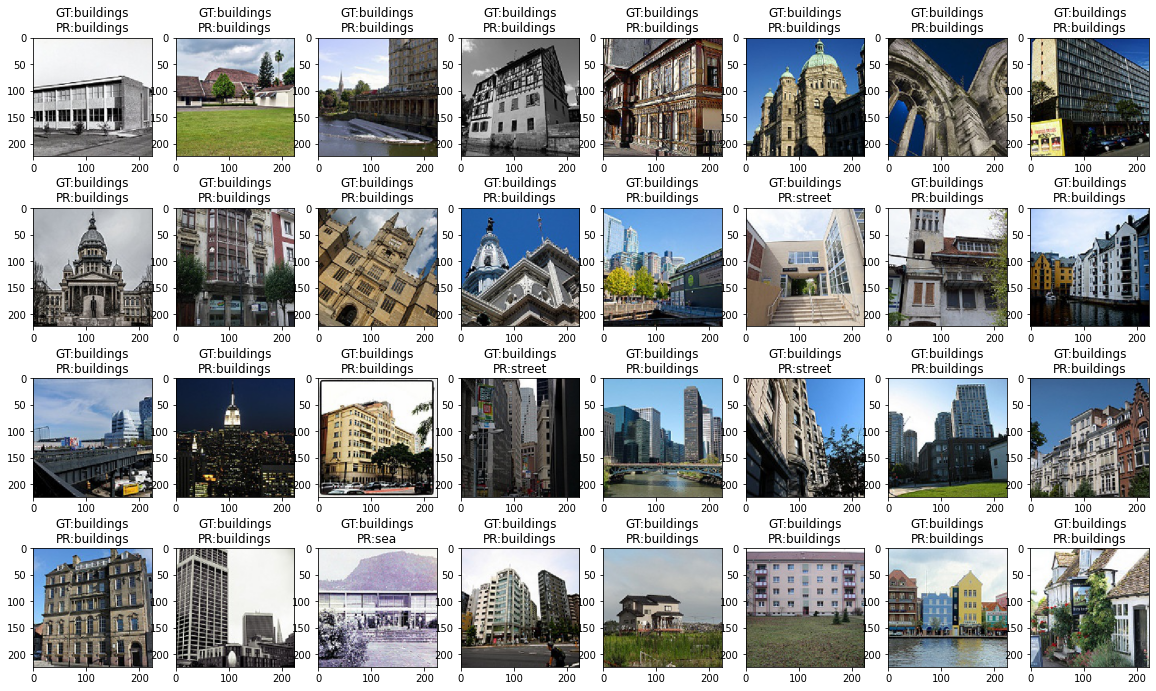

In [ ]:
test_imgs, test_labels = test_gen.__getitem__(1)

y_pred = model.predict(test_imgs)

classes = dict((v, k) for k, v in test_gen.class_indices.items())

fig, axes = plt.subplots(4, 8, figsize=(20, 12))

for img, test_label, pred_label, ax in zip(test_imgs, test_labels, y_pred, axes.flatten()):
  test_label = classes[np.argmax(test_label)]
  pred_label = classes[np.argmax(pred_label)]

  ax.set_title('GT:%s\nPR:%s' % (test_label, pred_label))
  ax.imshow(img)